In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def load(): 
    fremont_bridge = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
    
    bicycle_weather = 'https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv'

    counts = pd.read_csv(fremont_bridge, index_col='Date', parse_dates=True, 
                         infer_datetime_format=True)

    weather = pd.read_csv(bicycle_weather, index_col='DATE', parse_dates=True, 
                          infer_datetime_format=True)

    daily = counts.resample('d').sum()
    daily['Total'] = daily.sum(axis=1)
    daily = daily[['Total']] # remove other columns

    weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
    daily = daily.join(weather[weather_columns], how='inner')
    
    # Make a feature for yesterday's total
    daily['Total_yesterday'] = daily.Total.shift(1)
    daily = daily.drop(index=daily.index[0])
    
    return daily

In [3]:
def split(daily):
    # Hold out an "out-of-time" test set, from the last 100 days of data
    
    train = daily[:-100]
    test = daily[-100:]
    
    X_train = train.drop(columns='Total')
    y_train = train.Total

    X_test  = test.drop(columns='Total')
    y_test  = test.Total
    ""
    return X_train, X_test, y_train, y_test

In [4]:
def jake_wrangle(X):  
    X = X.copy()

    # patterns of use generally vary from day to day; 
    # let's add binary columns that indicate the day of the week:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i, day in enumerate(days):
        X[day] = (X.index.dayofweek == i).astype(float)


    # we might expect riders to behave differently on holidays; 
    # let's add an indicator of this as well:
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays('2012', '2016')
    X = X.join(pd.Series(1, index=holidays, name='holiday'))
    X['holiday'].fillna(0, inplace=True)


    # We also might suspect that the hours of daylight would affect 
    # how many people ride; let's use the standard astronomical calculation 
    # to add this information:
    def hours_of_daylight(date, axis=23.44, latitude=47.61):
        """Compute the hours of daylight for the given date"""
        days = (date - pd.datetime(2000, 12, 21)).days
        m = (1. - np.tan(np.radians(latitude))
             * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
        return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

    X['daylight_hrs'] = list(map(hours_of_daylight, X.index))


    # temperatures are in 1/10 deg C; convert to C
    X['TMIN'] /= 10
    X['TMAX'] /= 10

    # We can also calcuate the average temperature.
    X['Temp (C)'] = 0.5 * (X['TMIN'] + X['TMAX'])


    # precip is in 1/10 mm; convert to inches
    X['PRCP'] /= 254

    # In addition to the inches of precipitation, let's add a flag that 
    # indicates whether a day is dry (has zero precipitation):
    X['dry day'] = (X['PRCP'] == 0).astype(int)


    # Let's add a counter that increases from day 1, and measures how many 
    # years have passed. This will let us measure any observed annual increase 
    # or decrease in daily crossings:
    X['annual'] = (X.index - X.index[0]).days / 365.

    return X

In [5]:
data = load()

In [6]:
def wrangle(X):
    X = X.copy()
    X = X.replace(-9999, 0)
    X = jake_wrangle(X)
    
    # DS1 DH
    X['PRCP_yesterday'] = X.PRCP.shift(1).fillna(X.PRCP.mean())
    X['Windchill'] = (((X['Temp (C)'] * (9/5) + 32) * .6215) + 34.74) - (35.75 * (X['AWND']** .16)) + (.4275 * (X['Temp (C)'])) * (X['AWND'] ** .16)
    X['Rl_Cold'] = (((X['Temp (C)'] * (9/5) + 32) - X['Windchill']) -32) * (5/9)
    X['TMIN_squared'] = X['TMIN'] **2
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i, month in enumerate(months):
        X[month] = (X.index.month == i+1).astype(float)
    
    # DS3 JD
    X['light_rain'] = (X['PRCP'] > 0) & (X['PRCP'] < 0.10)
    X['moderate_rain'] = (X['PRCP'] >= 0.1) & (X['PRCP'] < 0.30)
    X['heavy_rain'] = (X['PRCP'] >= 0.30)
    X['weekend_day'] = (X['Sat'] == 1) | (X['Sun'] == 1)

    return X

In [23]:
# Split data into train and test
X_train, X_test, y_train, y_test = split(data)

# Do the same wrangling to X_train and X_test
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [46]:
X_train=X_train[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'Temp (C)', 'dry day', 'annual', 'PRCP_yesterday',
       'Windchill', 'Rl_Cold', 'TMIN_squared', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'light_rain',
       'moderate_rain', 'heavy_rain', 'weekend_day','Total_yesterday']]
X_test=X_test[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 
       'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'Temp (C)', 'dry day', 'annual', 'PRCP_yesterday',
       'Windchill', 'Rl_Cold', 'TMIN_squared', 'Jan', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'light_rain',
       'moderate_rain', 'heavy_rain', 'weekend_day','Total_yesterday']]

In [47]:
import category_encoders as ce
encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)

In [48]:
X_train.head()

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Mon,Tue,Wed,Thu,...,Aug,Sep,Oct,Nov,Dec,light_rain,moderate_rain,heavy_rain,weekend_day,Total_yesterday
2012-10-04,0.0,0,0,18.9,8.3,65,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,False,False,False,False,3521.0
2012-10-05,0.0,0,0,21.7,8.9,57,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,False,False,False,False,3475.0
2012-10-06,0.0,0,0,23.9,7.8,51,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,False,False,False,True,3148.0
2012-10-07,0.0,0,0,23.9,7.8,13,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,False,False,False,True,2006.0
2012-10-08,0.0,0,0,21.1,7.8,19,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,False,False,False,False,2142.0


In [41]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor


param_distributions = {
    'n_estimators':randint(50,100),
    'max_depth':randint(1,5)
}

search=RandomizedSearchCV(
      estimator=XGBRegressor(n_jobs=-1,random_state=42),
      param_distributions=param_distributions,
      n_iter=50,
      scoring='neg_mean_absolute_error',
      n_jobs=-1,
      cv=3,
      verbose=10,
      return_train_score=True)

search.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   18.1s finished
C:\Users\danie\Anaconda3\lib\site-packages\xgbo

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000012F6D12EB00>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000012F6D12EF98>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=10)

In [42]:
search.best_params_

{'max_depth': 4, 'n_estimators': 83}

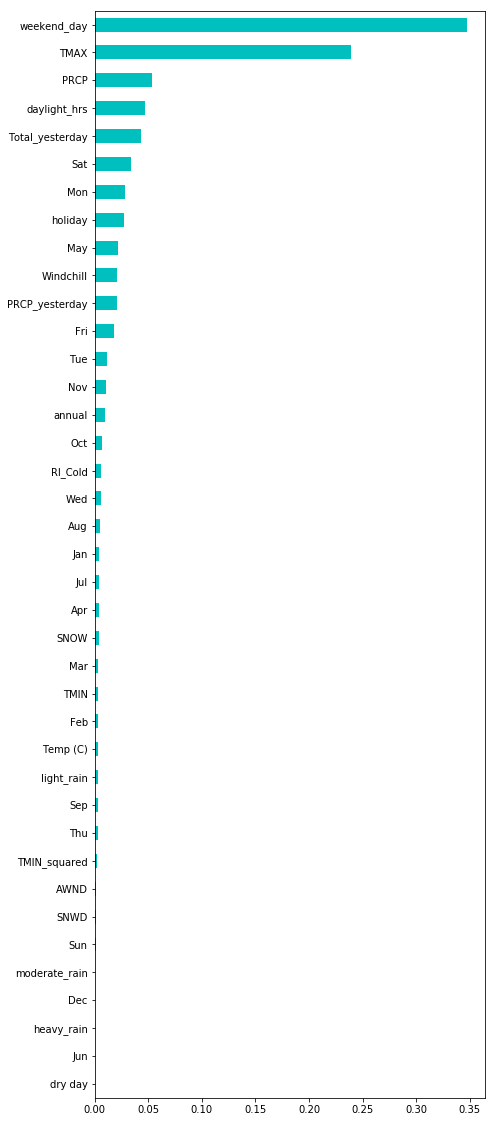

In [12]:
n = len(X_train.columns)
figsize = (7,20)

importances = pd.Series(search.best_estimator_.feature_importances_, X_train.columns)
top_n = importances.sort_values()[-n:]
plt.figure(figsize=figsize)
top_n.plot.barh(color='c');

In [44]:
#there is a well documented problem with xgboost and permutation importance and sparse matricies
best_est=XGBRegressor(max_depth=4, n_estimators= 82,n_jobs=-1,random_state=42)
best_est.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=82, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [52]:
#using this model instead
from sklearn.ensemble import RandomForestRegressor
tree=RandomForestRegressor(n_estimators=100,max_depth=15,n_jobs=-1,random_state=42)
tree.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [53]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(tree, scoring='neg_mean_absolute_error', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train.values, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_iter=2, random_state=42, refit=True,
           scoring='neg_mean_absolute_error')

In [54]:
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
567.8999 ± 11.2044,weekend_day
443.0278 ± 22.8165,TMAX
225.6753 ± 25.4740,PRCP
172.3777 ± 10.4589,daylight_hrs
111.7593 ± 3.8471,Total_yesterday
35.1349 ± 2.8671,annual
33.3853 ± 0.6915,Windchill
24.9457 ± 0.3504,Fri
21.1850 ± 0.5552,PRCP_yesterday
18.3099 ± 0.8032,holiday


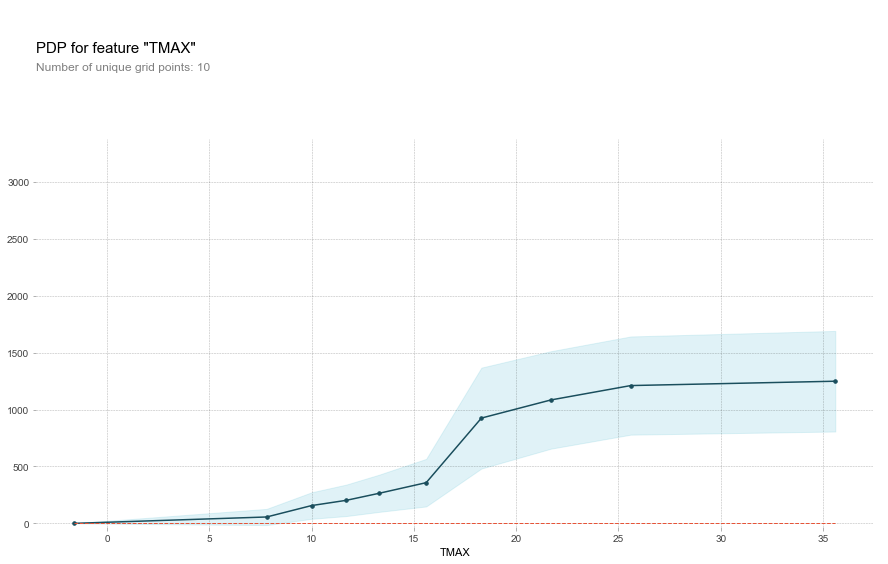

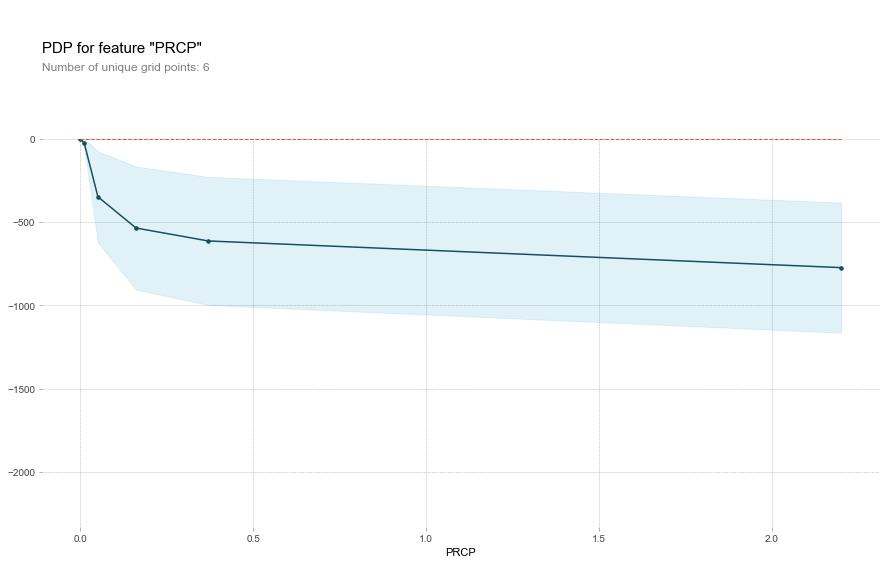

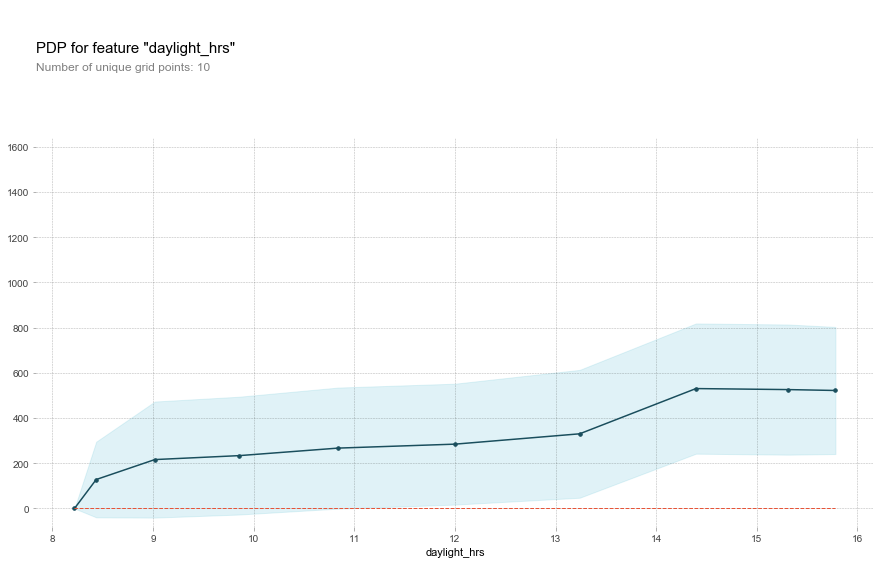

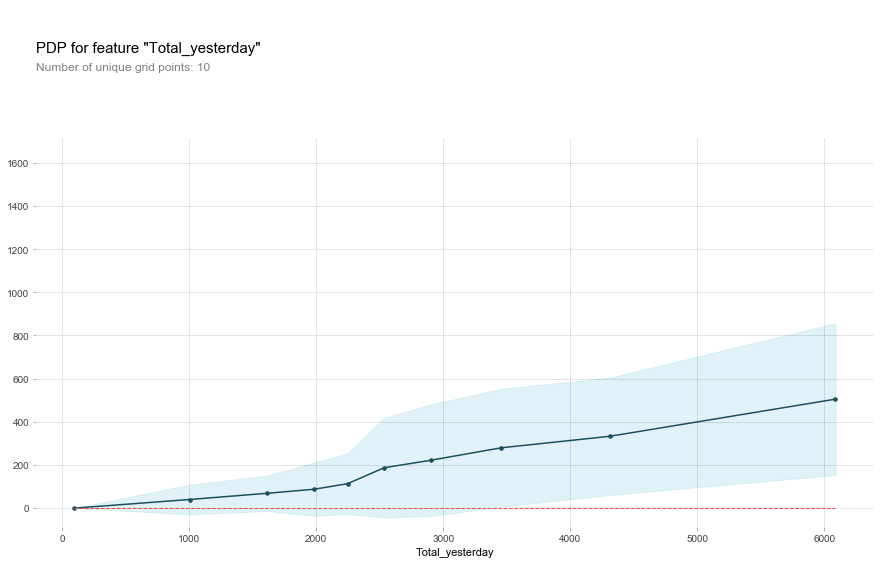

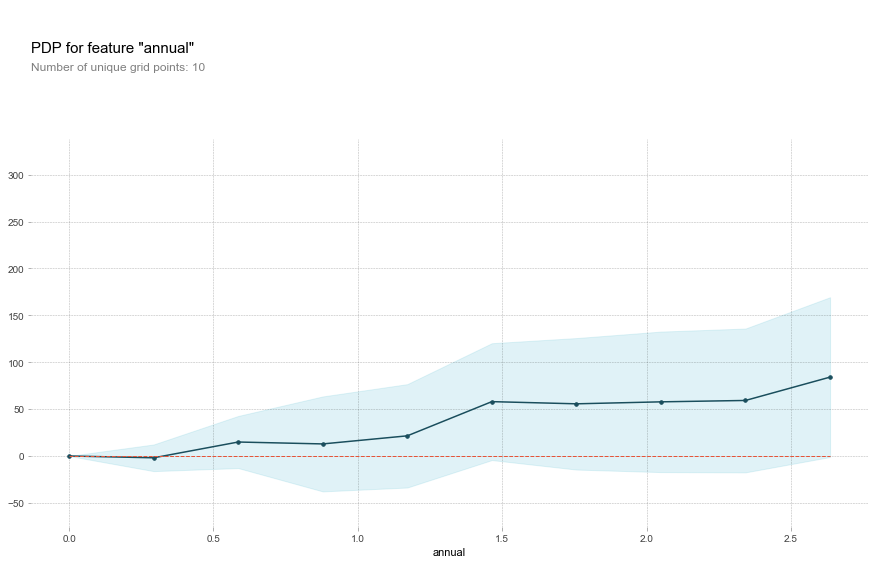

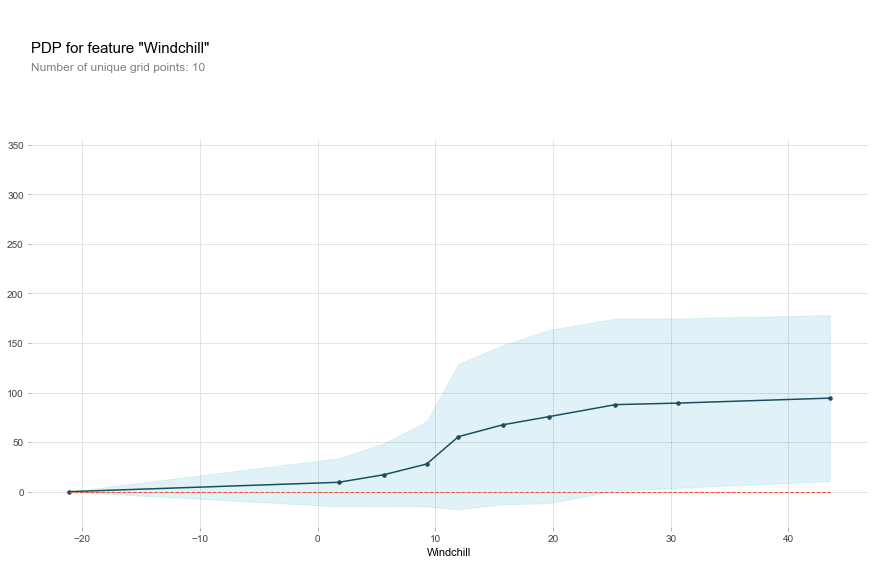

In [67]:
from pdpbox.pdp import pdp_isolate, pdp_plot

top6_nonbinary_features = ['TMAX','PRCP','daylight_hrs','Total_yesterday','annual','Windchill']

for feature in top6_nonbinary_features:
    isolated = pdp_isolate(
        model=tree, 
        dataset=X_train, 
        model_features=X_train.columns, 
        feature=feature
    )

    pdp_plot(isolated, feature_name=feature);

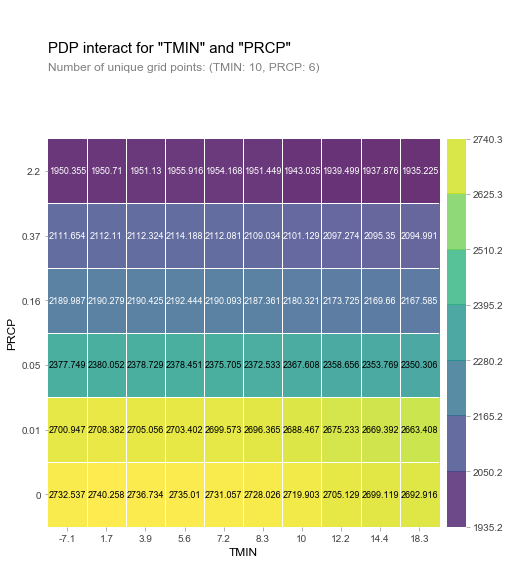

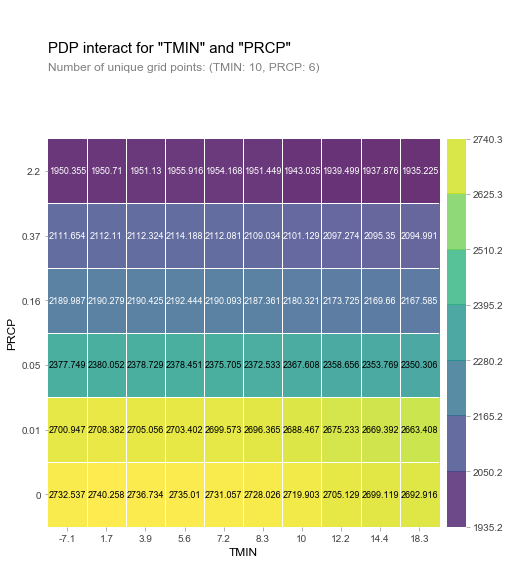

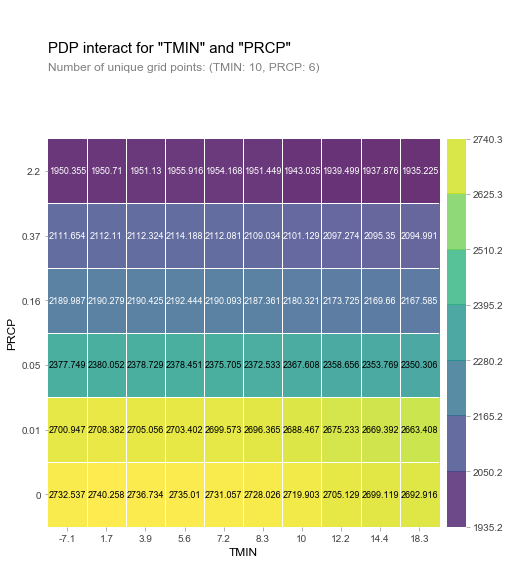

In [71]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

pairs = [['TMIN', 'PRCP'],['daylight_hrs','weekend_day'],['TMAX','Total_yesterday']]

for pair in pairs:
        interaction = pdp_interact(
        model=tree, 
        dataset=X_train, 
        model_features=X_train.columns, 
        features=features
    )

        pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [74]:
samples=X_train.sample(5)

In [87]:
samples.index

DatetimeIndex(['2012-12-07', '2014-01-18', '2014-05-25', '2013-02-10',
               '2014-05-20'],
              dtype='datetime64[ns]', freq=None)

In [78]:
samples.loc['2012-12-07']

,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Mon,Tue,Wed,Thu,...,Aug,Sep,Oct,Nov,Dec,light_rain,moderate_rain,heavy_rain,weekend_day,Total_yesterday
2012-12-07,0.03937,0,0,7.8,3.3,46,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,True,False,False,False,1879.0


In [88]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(tree)

sample=samples.loc['2012-12-07']
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values, sample)

In [89]:
sample=samples.loc['2014-01-18']
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values, sample)

In [90]:
sample=samples.loc['2014-05-25']
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values, sample)